# Testing

In [62]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from scipy.stats import norm
from sklearn.model_selection import train_test_split
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

Load the model

In [63]:
model = keras.models.load_model('model_strat_real.h5')

Load and preprocess the Data

In [64]:
a1 = yf.download("AAPL", start="2023-02-03", end="2023-03-25") 
a2 = yf.download("GOOG", start="2023-02-03", end="2023-03-25") 
a3 = yf.download("META", start="2023-02-03", end="2023-03-25") 
a4 = yf.download("MSFT", start="2023-02-03", end="2023-03-25") 
a5  = yf.download("AMZN", start="2023-02-03", end="2023-03-25")

a1 = a1["Close"]
a2 = a2["Close"]
a3 = a3["Close"]
a4 = a4["Close"]
a5 = a5["Close"]

df = pd.concat([a1,a2,a3,a4,a5],axis = 1)
df.to_csv("data/closing_prices.csv")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [65]:
Asset_1  = pd.read_csv("data/Apple.csv", header=None)
Asset_2 = pd.read_csv("data/Google.csv", header=None)
Asset_3  = pd.read_csv("data/Facebook.csv", header=None)
Asset_4  = pd.read_csv("data/Microsoft.csv", header=None)
Asset_5  = pd.read_csv("data/Amazon.csv", header=None)
closing_prices  = pd.read_csv("data/closing_prices.csv", header=None)

In [66]:
def preprocess_df(df,S_vals):
    df = df.fillna(0)
    dict_0 = {}
    scaling_factor = np.array(pd.to_numeric(S_vals[1:34])) # Scale all values such that value of underlying asset = 1
    dict_0["Strikes"] = [float(df.iloc[1][3*i])/scaling_factor for i in range(10)]    
    dict_0["Dates"] = list(df.iloc[3:36,0])
    dict_0["Bid"] = [list(pd.to_numeric(df.iloc[3:36,2+3*i])/scaling_factor) for i  in range(10)]
    dict_0["Ask"] = [list(pd.to_numeric(df.iloc[3:36,1+3*i])/scaling_factor) for i  in range(10)]
    dict_0["S"] = np.array(pd.to_numeric(S_vals[1:34])/scaling_factor)
    dict_0["Strikes_unscaled"] = [float(df.iloc[1][3*i]) for i in range(10)]    
    dict_0["Bid_unscaled"] = [list(pd.to_numeric(df.iloc[3:36,2+3*i])) for i  in range(10)]
    dict_0["Ask_unscaled"] = [list(pd.to_numeric(df.iloc[3:36,1+3*i])) for i  in range(10)]
    dict_0["S_unscaled"] = np.array(pd.to_numeric(S_vals[1:34]))
    return dict_0, scaling_factor



def X_to_Input(X_1,X_2,X_3,X_4,X_5,scaled = True):
    len_X = len(X_1["Dates"])
    if scaled:
        K = tf.concat([np.zeros((len_X,5)),
                       np.reshape([X_1['Strikes']],(len_X,10)),
                      np.reshape([X_2['Strikes']],(len_X,10)),
                      np.reshape([X_3['Strikes']],(len_X,10)),
                      np.reshape([X_4['Strikes']],(len_X,10)),
                      np.reshape([X_5['Strikes']],(len_X,10))],axis = 1)


        pi_minus = tf.concat([np.reshape(X_1["S"],(len_X,1)),
                              np.reshape(X_2["S"],(len_X,1)),
                              np.reshape(X_3["S"],(len_X,1)),
                              np.reshape(X_4["S"],(len_X,1)),
                              np.reshape(X_5["S"],(len_X,1)),
                              np.array(X_1['Bid']).transpose(),
                              np.array(X_2['Bid']).transpose(),
                              np.array(X_3['Bid']).transpose(),
                              np.array(X_4['Bid']).transpose(),
                              np.array(X_5['Bid']).transpose()],axis = 1)

        pi_plus = tf.concat([np.reshape(X_1["S"],(len_X,1)),
                              np.reshape(X_2["S"],(len_X,1)),
                              np.reshape(X_3["S"],(len_X,1)),
                              np.reshape(X_4["S"],(len_X,1)),
                              np.reshape(X_5["S"],(len_X,1)),
                              np.array(X_1['Ask']).transpose(),
                              np.array(X_2['Ask']).transpose(),
                              np.array(X_3['Ask']).transpose(),
                              np.array(X_4['Ask']).transpose(),
                              np.array(X_5['Ask']).transpose()],axis = 1)
    else:
        K = tf.concat([np.zeros((len_X,5)),
                       np.reshape([X_1['Strikes_unscaled']]*len_X,(len_X,10)),
                      np.reshape([X_2['Strikes_unscaled']]*len_X,(len_X,10)),
                      np.reshape([X_3['Strikes_unscaled']]*len_X,(len_X,10)),
                      np.reshape([X_4['Strikes_unscaled']]*len_X,(len_X,10)),
                      np.reshape([X_5['Strikes_unscaled']]*len_X,(len_X,10))],axis = 1)


        pi_minus = tf.concat([np.reshape(X_1["S_unscaled"],(len_X,1)),
                              np.reshape(X_2["S_unscaled"],(len_X,1)),
                              np.reshape(X_3["S_unscaled"],(len_X,1)),
                              np.reshape(X_4["S_unscaled"],(len_X,1)),
                              np.reshape(X_5["S_unscaled"],(len_X,1)),
                              np.array(X_1['Bid_unscaled']).transpose(),
                              np.array(X_2['Bid_unscaled']).transpose(),
                              np.array(X_3['Bid_unscaled']).transpose(),
                              np.array(X_4['Bid_unscaled']).transpose(),
                              np.array(X_5['Bid_unscaled']).transpose()],axis = 1)

        pi_plus = tf.concat([np.reshape(X_1["S_unscaled"],(len_X,1)),
                              np.reshape(X_2["S_unscaled"],(len_X,1)),
                              np.reshape(X_3["S_unscaled"],(len_X,1)),
                              np.reshape(X_4["S_unscaled"],(len_X,1)),
                              np.reshape(X_5["S_unscaled"],(len_X,1)),
                              np.array(X_1['Ask_unscaled']).transpose(),
                              np.array(X_2['Ask_unscaled']).transpose(),
                              np.array(X_3['Ask_unscaled']).transpose(),
                              np.array(X_4['Ask_unscaled']).transpose(),
                              np.array(X_5['Ask_unscaled']).transpose()],axis = 1)        
    
    return [K,pi_minus,pi_plus]


# Computation of the profit

# 1. With the scaled Assets

In [67]:
Asset_1_dict, Asset_1_scaling_factor = preprocess_df(Asset_1,closing_prices[1])
Asset_2_dict, Asset_2_scaling_factor = preprocess_df(Asset_2,closing_prices[2])
Asset_3_dict, Asset_3_scaling_factor = preprocess_df(Asset_3,closing_prices[3])
Asset_4_dict, Asset_4_scaling_factor = preprocess_df(Asset_4,closing_prices[4])
Asset_5_dict, Asset_5_scaling_factor = preprocess_df(Asset_5,closing_prices[5])


# Determine the Strategy
X = X_to_Input(Asset_1_dict,Asset_2_dict,Asset_3_dict,Asset_4_dict,Asset_5_dict)
X_unscaled = X_to_Input(Asset_1_dict,Asset_2_dict,Asset_3_dict,Asset_4_dict,Asset_5_dict,scaled = False)

strat = model(X)

# Compute S
N_days = len(X[0])
S_T = np.array(pd.to_numeric(closing_prices.iloc[-1][1:]))
S_T_Scaled = np.repeat(S_T[:,np.newaxis],N_days,axis = 1) / np.array([Asset_1_scaling_factor,
                         Asset_2_scaling_factor,
                         Asset_3_scaling_factor,
                         Asset_4_scaling_factor,
                         Asset_5_scaling_factor])

# Computed the prices of the strategies
a = strat[0]
sell = tf.reshape(tf.reduce_sum(tf.cast(X[1],tf.float32)*strat[1],1),(N_days,1))
buy = tf.reshape(tf.reduce_sum(tf.cast(X[2],tf.float32)*strat[2],1),(N_days,1))
Price = a + buy - sell

#assets = np.array([S]*33)
Calls_1 = np.maximum(S_T_Scaled[0]-np.array(Asset_1_dict["Strikes"]),0)
Calls_2 = np.maximum(S_T_Scaled[1]-np.array(Asset_2_dict["Strikes"]),0)
Calls_3 = np.maximum(S_T_Scaled[2]-np.array(Asset_3_dict["Strikes"]),0)
Calls_4 = np.maximum(S_T_Scaled[3]-np.array(Asset_4_dict["Strikes"]),0)
Calls_5 = np.maximum(S_T_Scaled[4]-np.array(Asset_5_dict["Strikes"]),0)

# Compute the Payoff

Payoffs = tf.transpose(tf.concat([(S_T_Scaled),Calls_1,Calls_2,Calls_3,Calls_4,Calls_5],0))

Payoff_T = a + tf.reshape(tf.reduce_sum((strat[2]-strat[1])*tf.cast(Payoffs,tf.float32),1),(N_days,1))

profit = Payoff_T-Price      

In [68]:
pd.DataFrame(profit.numpy()).describe()

,0
count,33.000000
mean,0.063460
std,0.089347
min,-0.017063
25%,-0.007025
50%,0.021668
75%,0.093558
max,0.318201


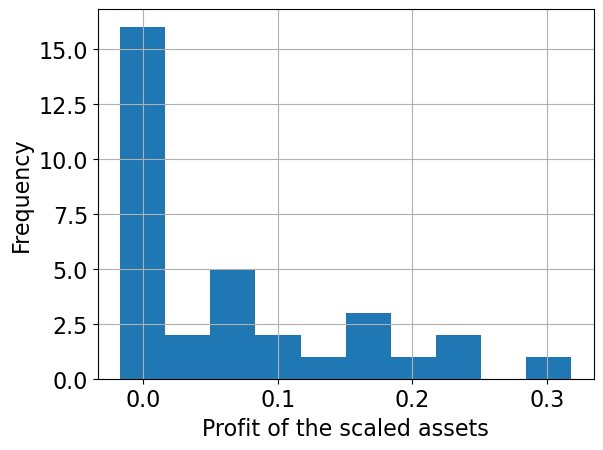

In [69]:
plt.hist(np.reshape(profit,-1))
plt.xlabel("Profit of the scaled assets")
plt.ylabel("Frequency")
plt.grid(True)
plt.savefig("Histogram_real.pdf")
plt.show()



# 2.) With the unscaled Assets

In [70]:
Asset_1_dict, Asset_1_scaling_factor = preprocess_df(Asset_1,closing_prices[1])
Asset_2_dict, Asset_2_scaling_factor = preprocess_df(Asset_2,closing_prices[2])
Asset_3_dict, Asset_3_scaling_factor = preprocess_df(Asset_3,closing_prices[3])
Asset_4_dict, Asset_4_scaling_factor = preprocess_df(Asset_4,closing_prices[4])
Asset_5_dict, Asset_5_scaling_factor = preprocess_df(Asset_5,closing_prices[5])


# Determine the Strategy
X = X_to_Input(Asset_1_dict,Asset_2_dict,Asset_3_dict,Asset_4_dict,Asset_5_dict)
X_unscaled = X_to_Input(Asset_1_dict,Asset_2_dict,Asset_3_dict,Asset_4_dict,Asset_5_dict,scaled = False)

strat = model(X)

# Compute S
N_days = len(X[0])
S_T = np.array(pd.to_numeric(closing_prices.iloc[-1][1:]))
S_T_Scaled = np.repeat(S_T[:,np.newaxis],N_days,axis = 1) / np.array([Asset_1_scaling_factor,
                         Asset_2_scaling_factor,
                         Asset_3_scaling_factor,
                         Asset_4_scaling_factor,
                         Asset_5_scaling_factor])

# Computed the prices of the strategies
a = strat[0]
sell_unscaled = tf.reshape(tf.reduce_sum(tf.cast(X_unscaled[1],tf.float32)*strat[1],1),(N_days,1))
buy_unscaled = tf.reshape(tf.reduce_sum(tf.cast(X_unscaled[2],tf.float32)*strat[2],1),(N_days,1))
Price_unscaled = a + buy_unscaled - sell_unscaled


# Compute the Payoff
#assets = np.array([S]*33)
Calls_1_unscaled = np.maximum(S_T[0]-np.array(Asset_1_dict["Strikes_unscaled"]),0)
Calls_2_unscaled = np.maximum(S_T[1]-np.array(Asset_2_dict["Strikes_unscaled"]),0)
Calls_3_unscaled = np.maximum(S_T[2]-np.array(Asset_3_dict["Strikes_unscaled"]),0)
Calls_4_unscaled = np.maximum(S_T[3]-np.array(Asset_4_dict["Strikes_unscaled"]),0)
Calls_5_unscaled = np.maximum(S_T[4]-np.array(Asset_5_dict["Strikes_unscaled"]),0)
Payoffs_unscaled = tf.concat([(S_T),Calls_1_unscaled,Calls_2_unscaled,
                                           Calls_3_unscaled,Calls_4_unscaled,Calls_5_unscaled],0)
Payoffs_unscaled = tf.repeat(tf.reshape(Payoffs_unscaled,(1,55)),N_days,axis = 0)

Payoff_T_unscaled = a + tf.reshape(tf.reduce_sum((strat[2]-strat[1])*tf.cast(Payoffs_unscaled,tf.float32),1),(N_days,1))

profit_unscaled  = Payoff_T_unscaled-Price_unscaled      

In [71]:
pd.DataFrame(profit_unscaled.numpy()).describe()

,0
count,33.000000
mean,5.855233
std,9.706270
min,-4.225227
25%,-1.475227
50%,1.535172
75%,13.032318
max,32.687988


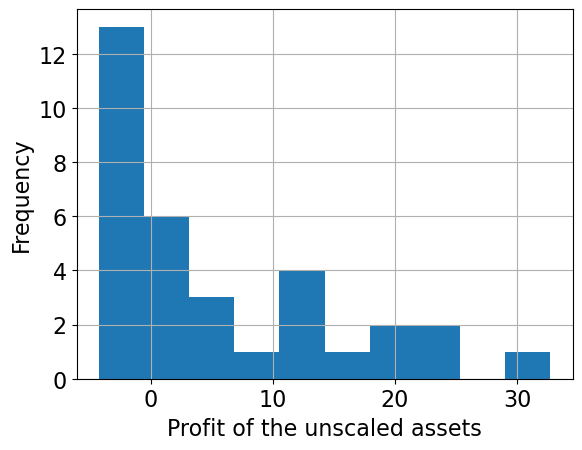

In [72]:
plt.hist(np.reshape(profit_unscaled,-1))
plt.xlabel("Profit of the unscaled assets")
plt.ylabel("Frequency")
plt.grid(True)
plt.savefig("Histogram_real_unscaled.pdf",bbox_inches='tight')
plt.show()